In [1]:
import pandas as pd
from pandas import np
%matplotlib inline
from matplotlib import pyplot as plt
from statsmodels import api as sm
tsa = sm.tsa

# Data exploration

Mali Akmanalp, Jose Morales Arilla, Kevin Shain

We have a few different candidates as a possible indicator to use as a prediction target. The first dataset we'll look at is the [Consumer Confidence Index](https://en.wikipedia.org/wiki/Consumer_confidence_index), which is a monthly household survey that is benchmarked to have the value 100 for the year 1985.

In [5]:
df = pd.read_csv("./CCI.csv")
df = df[["TIME", "Value"]]
df.columns = ["time", "value"]

First, we can look at the CCI values over time: let's plot the values:

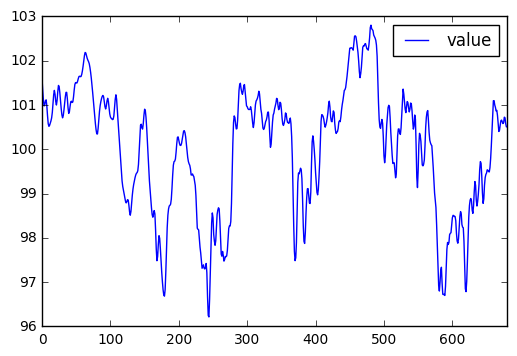

In [6]:
df.plot()

The CCI seems to mostly be centered around 100, and we're mostly interested in the changes that happen rather than the actual absolute value. To look at the change over time, we can also look at the differences of the values, which gives us a more interesting figure:

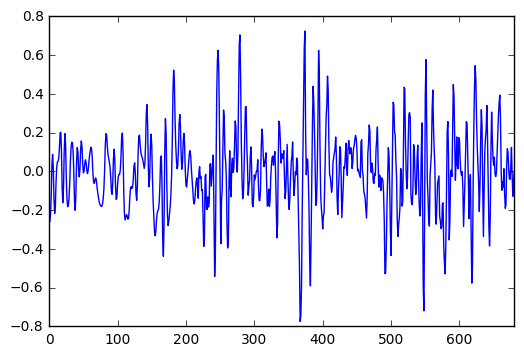

In [7]:
df.value.diff().plot()

We can also look at the distribution of the values:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114e5cb10>]], dtype=object)

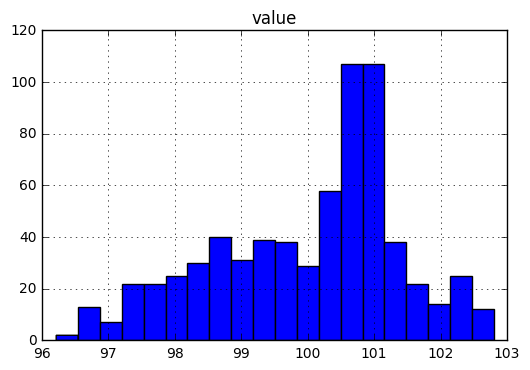

In [13]:
df.hist(bins=20)

Above 100 in general. Also, the above graphs look like they have a common time cycle trend and then noise around that. We can try to use the Hodrick–Prescott filter to separate the cycle and the noise:

In [8]:
a, b = tsa.filters.hpfilter(df.value)

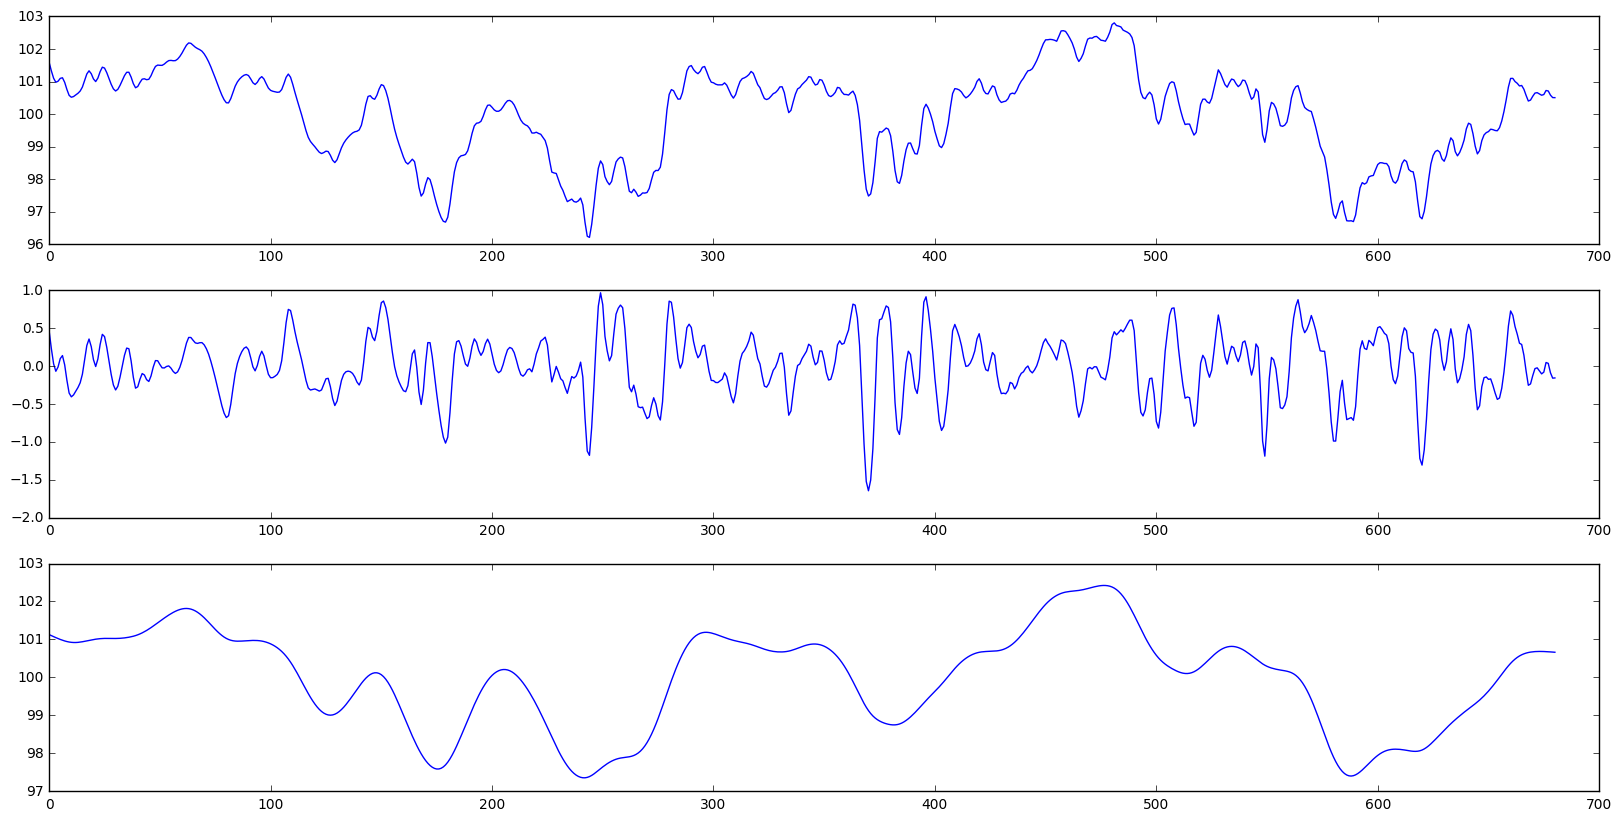

In [10]:
fig, ax = plt.subplots(3,1, figsize=(20, 10))
ax[0].plot(df.value)
ax[1].plot(a)
ax[2].plot(b)

## Unit root test: Augmented Dickey-Fuller

So is the value stationary? We can use the augmented Dickey-Fuller test to find out. To do this, we have to test all three forms, and if we find that the resulting statistic's absolute value is higher than the 1/5/10% critical values, we can conclude one way or the other. The results:

No drift and deterministic trends: Unit root (5%)

In [63]:
tsa.adfuller(df.value, regression="nc")

(-0.12518383149447002,
 0.64110728130924999,
 4,
 676,
 {'1%': -2.5690553334091941,
  '10%': -1.6164329575279444,
  '5%': -1.941404599830473},
 -1256.0739303517457)

Drift only: Stationary (5%)

In [40]:
tsa.adfuller(df.value, regression="c")

(-3.2780882592117213,
 0.015886796188168056,
 14,
 666,
 {'1%': -3.4402068818114708,
  '10%': -2.5690862428193961,
  '5%': -2.8658894709126246},
 -1262.8076656501144)

Drift + Deterministic trend: Unit Root (5%)

In [41]:
tsa.adfuller(df.value, regression="ct")

(-3.269211945593832,
 0.071471314966745358,
 14,
 666,
 {'1%': -3.9724277884955539,
  '10%': -3.1309412069808631,
  '5%': -3.4171027175128486},
 -1260.8185912869417)

So we can conclude that this is unit root, and not stationary. We can also look at the difference:

In [69]:
tsa.adfuller(df.value.diff()[1:], regression="nc")

(-11.764285427996542,
 2.0497076446844373e-21,
 3,
 676,
 {'1%': -2.5690553334091941,
  '10%': -1.6164329575279444,
  '5%': -1.941404599830473},
 -1255.3356911531428)

In [70]:
tsa.adfuller(df.value.diff()[1:], regression="c")

(-11.755897224910441,
 1.1788975910714379e-21,
 3,
 676,
 {'1%': -3.4400605106273368,
  '10%': -2.5690518865761001,
  '5%': -2.8658249865874121},
 -1253.3404932351591)

In [72]:
tsa.adfuller(df.value.diff()[1:], regression="ct")

(-11.755278792074245,
 9.7538813824319566e-19,
 3,
 676,
 {'1%': -3.9722248029965295,
  '10%': -3.1308835135904487,
  '5%': -3.4170045949049879},
 -1251.4890884097554)

Here, it's pretty obviously stationary.

We can generalize this into a function, like this:

In [16]:
def is_unit_root(data, threshold="5%"):
    
    nc = tsa.adfuller(data, regression="nc")
    c = tsa.adfuller(data, regression="c")
    ct = tsa.adfuller(data, regression="ct")
    
    votes = 0
    for test in [nc, c, ct]:
        if(abs(test[0]) < abs(test[4][threshold])):
            votes += 1
            
    return votes >= 2, {"nc": nc, "c":c, "ct":ct}

In [82]:
result, parameters = is_unit_root(df.value)

In [83]:
result

True

In [85]:
parameters["c"]

(-3.2780882592117213,
 0.015886796188168056,
 14,
 666,
 {'1%': -3.4402068818114708,
  '10%': -2.5690862428193961,
  '5%': -2.8658894709126246},
 -1262.8076656501144)

In [21]:
cli = pd.read_csv("./CLI.csv")
cli = cli[["TIME", "Value"]]
cli.columns = ["time", "value"]

In [22]:
result, parameters = is_unit_root(cli.value)

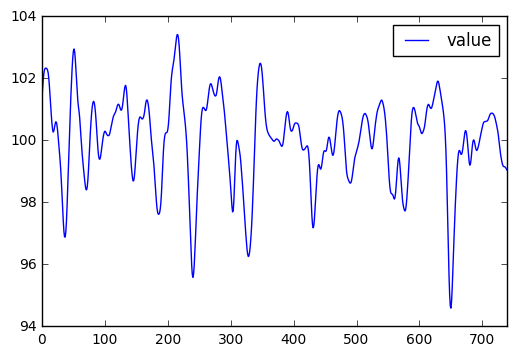

In [23]:
cli.plot()

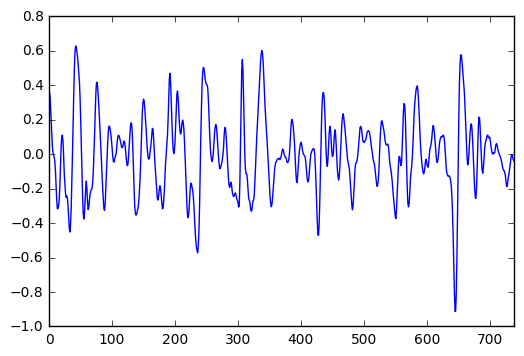

In [27]:
cli.value.diff().plot()